In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange

%matplotlib inline

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
df = pd.read_csv('./rating_data.csv')
df_array = df.as_matrix()

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d" % (total_usr, total_item))

sparsity of ratings is 3.82%
num. of users: 5000, num. of items: 99


In [3]:
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(df_array, test_size=0.2)

rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in df_array:
    rating[line[0]-1, line[1]-1] = 1 if line[2] > 3 else 0

### Drop users' rating that less than 5

In [4]:
a = [usr_idx for usr_idx in range(rating.shape[0]) if np.count_nonzero(rating[usr_idx]) < 5]
rating = np.delete(rating, a, axis=0)
# a = [item_idx for item_idx in range(rating.shape[1]) if np.count_nonzero(rating.T[item_idx]) == 0]
# rating = np.delete(rating, a, axis=1)

n_u = rating.shape[0]
n_i = rating.shape[1]
count = 0

for line in rating:
    count += np.count_nonzero(line)
sparsity = count/(n_u*n_i)    
print ("new sparsity of ratings is %.2f%%" % (sparsity*100))
print (n_u, n_i)

new sparsity of ratings is 7.04%
332 99


## MAP@5 with various drop_rate

In [5]:
drop_rate = [0., 0.2, 0.4, 0.6, 0.8]
mAP = []

for rate in drop_rate:
    tf.reset_default_graph()
    sess = tf.Session()
    X = tf.placeholder(tf.float32, shape=(1, n_i))
    Y = tf.placeholder(tf.float32, shape=(1, n_i))

    autoencoder = AutoEncoder(sess=sess, inputs=X, user_num=n_u, hidden_units=20,
                              item_num=n_i, targets=Y, lr=0.01, epochs=50, dropout_rate=rate, 
                              cost_function='log_loss')
    autoencoder.train(rating=rating)
    ap = autoencoder.averagePrecision(rating)
    mAP.append(sum(ap)/len(ap))

100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


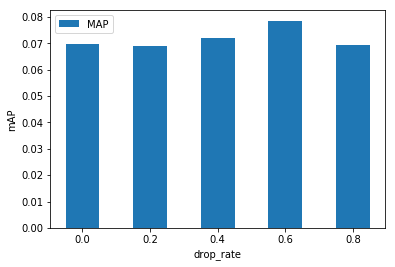

In [6]:
plt.bar(drop_rate, mAP, width=0.1, label='MAP')
plt.legend(loc='upper left')
plt.xticks(drop_rate)
plt.xlabel('drop_rate')
plt.ylabel('mAP')
plt.show()

## Build Model and Training

In [17]:
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=(1, n_i))
Y = tf.placeholder(tf.float32, shape=(1, n_i))

autoencoder = AutoEncoder(sess=sess, inputs=X, user_num=n_u, hidden_units=20,
                          item_num=n_i, targets=Y, lr=0.01, epochs=50, dropout_rate=0.6,
                          cost_function='log_loss')
autoencoder.train(rating=rating)

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


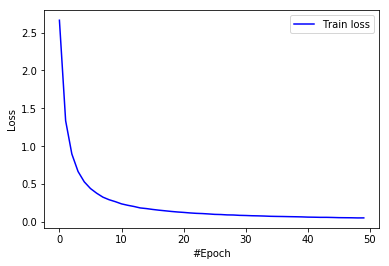

In [18]:
train_loss = autoencoder.log['train_loss']
test_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

## MAP@5

In [19]:
ap = autoencoder.averagePrecision(rating)

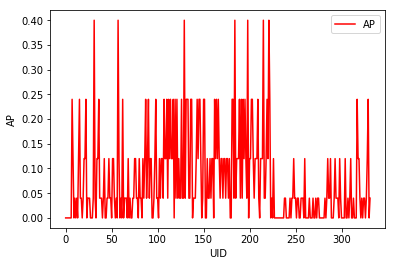

In [20]:
plt.plot(range(len(ap)), ap, color='red', label='AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('UID')
plt.ylabel('AP')
plt.show()

In [21]:
print (sum(ap)/len(ap))

0.0785542168674697


## Top20 Videos

In [22]:
rank = []
for item_id, idx in enumerate(range(rating.shape[1])):
    rank.append(np.count_nonzero(rating.T[idx]))
    
rank = np.asarray(rank)
rank_ = rank.argsort()
top20 = rank.argsort()[-20:][::-1]

In [23]:
recon_rank = {}
for usr in range(rating.shape[0]):
    recon = autoencoder.recon.eval(
        session=autoencoder.sess,
        feed_dict={
            autoencoder.inputs: [rating[usr]],
            autoencoder.user_id: usr
        })
    
    usrTop20 = recon[0].argsort()[-20:][::-1]
    for item in usrTop20:
        if item in recon_rank:
            recon_rank[item] += 1
        else:
            recon_rank[item] = 1

In [24]:
a = np.asarray(list(recon_rank.items()))
recon_top20 = np.sort(a, axis=1)[-20:, 0]
print (recon_top20)
print (top20)

[82 17  2 27 57 56 76 78 75 96  4  0 90 43  7 47 32  5 51 45]
[29 27 82  2 17 57 96 56 43  4 47 75 78 76  0 90 51  7 46 32]


### hit rate

In [25]:
count = 0
for i in recon_top20:
    count += 1 if i in top20 else 0

print (count/20)

0.9


### where are them originally

In [26]:
rank_list = list(rank_)
for item in recon_top20:
    if item not in top20:
        print ("item %d: %d" % (item, rank_list.index(item)))

item 5: 72
item 45: 78
